Part 1:

Instructions for part 1:
In this part use the same dataset as you used for the first two homework.

1- Pick two frequencies of 5 Hz and 25 Hz and electrode of Cz.

Then perform complex Morlet wavelet convolution and filter-Hilbert using those two frequencies as the peak/ center frequencies for all trials.

Plot the resulting power and the bandpass-filtered signal (that is, the real component of the analytic signal) from each method (you need to plot the average of all the trials). 

Describe some similarities and differences between the results of the two time-frequency decomposition methods.

Note:
 You need to generate the analytic form of the signal similar to what “hilbert” Matlab
function does.

 Do not use any pre-written Matlab function (e.g., “hilbert’) for generating your results.

Import necessary functions and libraries.

In [160]:
import numpy as np
# , cmath, scipy as sp
import scipy.io
from matplotlib import pyplot as plt

#import basic functions from numpy that we'll need
from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle, real, imag  
from numpy import zeros, ceil, floor, absolute, linspace
from numpy.fft import fft, ifft
from scipy import signal as sig
from scipy.signal import hilbert

# from matplotlib.pyplot import *

%matplotlib inline

In [161]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]
EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

In [162]:
from firls import firls
#this is a Python firls() implementation taken from
#http://projects.scipy.org/scipy/attachment/ticket/648/designtools.py

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  q = toeplitz(q[:M+1]) + hankel(q[:M+1], q[M : ])
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:90: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  b = append(1, 1.0/i1) * array(mat(kron (cos_ints2, [1, 1]) + cos_ints[:M+1,:]) * mat(d).T)[:,0]


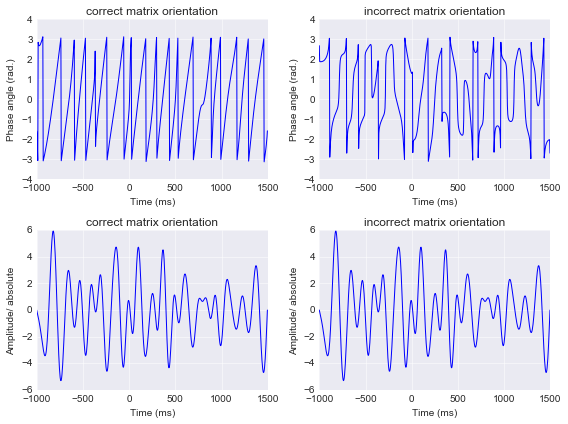

In [111]:
# Pick two frequencies of 5 Hz and 25 Hz and electrode of Cz
# In this scenario: 5 is low and 25 is high freq

# first, filter data (filter mechanisms will be explained more below; for now, focus on 
# using the phases from the Hilbert transform to test whether the matrix input was correct)
nyquist = EEGsrate/2. #hz
lower_filter_bound = 4. #hz
upper_filter_bound = 10. #hz

transition_width = 0.2
filter_order = np.round(3*EEGsrate/lower_filter_bound)

#create filter shape
ffrequencies = np.array([0, (1-transition_width) * lower_filter_bound, 
                        lower_filter_bound, upper_filter_bound, 
                         (1 + transition_width)* upper_filter_bound, nyquist]) / nyquist

# firls: filter infinite response with least square
idealresponse = np.array([0,0,1,1,0,0])
filterweights = firls(filter_order,ffrequencies,idealresponse) #use firls script described above

#apply the filter kernal to the data to obtain the band-pass filtered signal
filtered_data = zeros([EEGnbchan,EEGpnts]);

for chani in range(EEGnbchan):
    filtered_data[chani,:] = sig.filtfilt(filterweights,1,EEGdata[chani,:,0])

#  apply hilbert transform in correct and incorrect orientations
hilbert_oops = hilbert(filtered_data, axis=0);
hilbert_yes  = hilbert(filtered_data, axis=1); #compute it along the last axis 

#  Note that the output of the hilbert transform is transposed to bring us back to an electrode X time matrix.
plt.figure(figsize=[8,6])

plt.subplot(221)
plt.plot(EEGtimes,angle(hilbert_yes[0,:]),'b');
plt.title('correct matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('Phase angle (rad.)')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.subplot(222)
plt.plot(EEGtimes,angle(hilbert_oops[0,:]),'b');
plt.title('incorrect matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('Phase angle (rad.)')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.subplot(223)
plt.plot(EEGtimes,real(hilbert_yes[0,:]),'b');
plt.title('correct matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('Amplitude/ absolute')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.subplot(224)
plt.plot(EEGtimes,real(hilbert_oops[0,:]),'b');
plt.title('incorrect matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('Amplitude/ absolute')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.tight_layout()

In [112]:
filtered_data.shape

(64, 640)

### Figure 14.3

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  q = toeplitz(q[:M+1]) + hankel(q[:M+1], q[M : ])
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:90: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  b = append(1, 1.0/i1) * array(mat(kron (cos_ints2, [1, 1]) + cos_ints[:M+1,:]) * mat(d).T)[:,0]


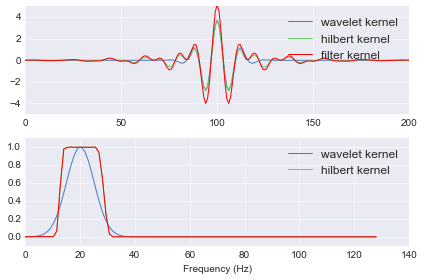

In [132]:
from scipy.stats.mstats import zscore

center_freq = 20 #in hz
filter_frequency_spread = 6 #Hz, +- center frequency
wavelet_frequency_spread = 4

#create wavelet
time = np.arange(-1000/EEGsrate/10.,1000/EEGsrate/10. + 1/EEGsrate,1/EEGsrate)

wavelet = exp(2*1j*pi*center_freq*time) * exp(-time**2/(2*(wavelet_frequency_spread/(2*pi*center_freq))**2))
wavelet = zscore(wavelet)

#compute its power spectrum
fft_wavelet = absolute(fft(wavelet))
fft_wavelet /= np.max(fft_wavelet) #normalized to one for visual comparison case

hz_wavelet = np.linspace(0,nyquist,len(time)/2. + 1) 

#construct filter kernel
transition_width = 0.2

ffrequencies   = np.array([ 0, (1-transition_width)*(center_freq-filter_frequency_spread),
                  (center_freq-filter_frequency_spread),
                  (center_freq+filter_frequency_spread),
                  (1+transition_width)*(center_freq+filter_frequency_spread),
                  nyquist ])/nyquist;

# # Compute Hilbert Kernel
# f = fft(time)
# n = time.shape[0] # len(time)
# complexf = 1j*f
# posF = np.arange(1, floor(n/2) + (n%2)).astype(int)
# negF = np.arange(ceil(n/2) + (~n%2), n).astype(int)
# f[posF] = f[posF] - (1j*complexf[posF])
# f[negF] = f[negF] + (1j*complexf[negF])
# hilbert_kernel = ifft(f)

#  Compute Hilbert kernel
filterweights = firls(200, ffrequencies, idealresponse)
hilbert_kernel = hilbert(filterweights)
hilbert_kernel = zscore(hilbert_kernel)

# Compute its power spectrum
fft_hilbert_kernel = absolute(fft(hilbert_kernel))
fft_hilbert_kernel /= np.max(fft_hilbert_kernel)

# hz_hilbert = np.linspace(0,nyquist,101) #list of frequencies in hz corresponding to fitler kernel
hz_hilbert = np.linspace(0,nyquist,101) 

#  firls
idealresponse = np.array([0,0,1,1,0,0])
filterweights = zscore(firls(200,ffrequencies,idealresponse))

#also compute weights using firwin
filterweights1=zscore(sig.firwin(201,np.array([center_freq-filter_frequency_spread,
                                  center_freq+filter_frequency_spread])/nyquist))

#compute its power spectrum
fft_filtkern = np.absolute(fft(filterweights))
fft_filtkern /=np.max(fft_filtkern) #again normalize to 1 for comparison

fft_filtkern1 = np.absolute(fft(filterweights1))[:-1]
fft_filtkern1 /=np.max(fft_filtkern1)

hz_filtkern = np.linspace(0,nyquist,101) #list of frequencies in hz corresponding to fitler kernel

#plot wavelet and filter kernel
plt.subplot(211)
plt.plot(real(wavelet))
plt.plot(real(hilbert_kernel))
plt.plot(filterweights,'r')
plt.legend(["wavelet kernel", 'hilbert kernel', "filter kernel"])
plt.setp(plt.gca(),'xlim',[0, 200],'ylim',[-5, 5])

#plot power spectra
plt.subplot(212)
# plt.plot(fft_wavelet)
# # plt.plot(fft_hilbert_kernel)
# plt.plot(fft_filtkern)
# plt.plot(fft_filtkern1)
plt.plot(hz_wavelet,fft_wavelet[:int(ceil(len(fft_wavelet)/2.))])
plt.plot(hz_hilbert,fft_hilbert_kernel[:int(ceil(len(fft_hilbert_kernel)/2.))])
plt.plot(hz_filtkern,fft_filtkern[:int(ceil(len(fft_filtkern)/2.))],'r')
plt.legend(['wavelet kernel','hilbert kernel'])
plt.setp(plt.gca(),'ylim',[-.1, 1.1])
plt.xlabel('Frequency (Hz)')

plt.tight_layout()

# plt.subplot(213)
# plt.plot(fft_hilbert_kernel)
# plt.plot(hilbert_kernel)



In [133]:
time.shape, f.shape, ffrequencies.shape, len(time)/2.

((201,), (201,), (6,), 100.5)

In [134]:
(fft_hilbert_kernel.shape, nyquist, hz_wavelet.shape, hz_filtkern.shape, hz_filtkern.shape, fft_wavelet.shape, 
fft_filtkern.shape, fft_filtkern1.shape, hilbert_kernel.shape)

((201,), 128.0, (101,), (101,), (101,), (201,), (201,), (200,), (201,))

In [135]:
ffrequencies.shape

(6,)

### Figure 14.3

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  q = toeplitz(q[:M+1]) + hankel(q[:M+1], q[M : ])
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:90: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  b = append(1, 1.0/i1) * array(mat(kron (cos_ints2, [1, 1]) + cos_ints[:M+1,:]) * mat(d).T)[:,0]


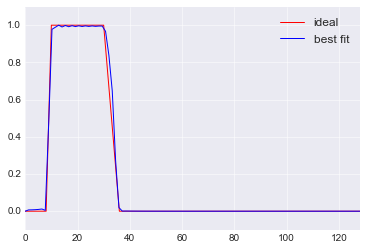

In [142]:
center_freq = 20. #in Hz
filter_frequency_spread_wide = 10 # Hz - center frequency

ffrequencies   = np.array([ 0,
                  (1-transition_width)*(center_freq-filter_frequency_spread_wide),
                  (center_freq-filter_frequency_spread_wide) ,
                  (center_freq+filter_frequency_spread_wide), 
                  (1+transition_width)*(center_freq+filter_frequency_spread_wide) ,
                  nyquist ])/nyquist;

idealresponse = np.array([0,0,1,1,0,0])

filterweightsW = zscore(firls(200,ffrequencies,idealresponse))
fft_filtkern = absolute(fft(filterweightsW))
fft_filtkern = fft_filtkern/np.max(fft_filtkern) #normalized to 1 for visualization

plt.plot(ffrequencies*nyquist,idealresponse,'r')
plt.plot(hz_filtkern,fft_filtkern[:int(ceil(len(fft_filtkern)/2.))],'b')

plt.axis([0,nyquist,-.1,1.1])
plt.legend(["ideal",'best fit'])

In [143]:
nyquist, ffrequencies.shape, idealresponse.shape

(128.0, (6,), (6,))

### Figure 14.5

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  q = toeplitz(q[:M+1]) + hankel(q[:M+1], q[M : ])
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:90: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  b = append(1, 1.0/i1) * array(mat(kron (cos_ints2, [1, 1]) + cos_ints[:M+1,:]) * mat(d).T)[:,0]


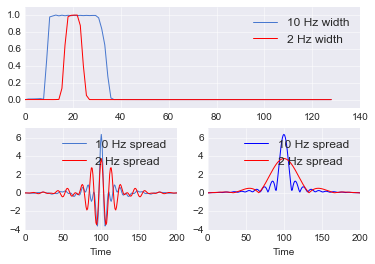

In [146]:
center_freq = 20 # in Hz
filter_frequency_spread_wide = 10 # Hz +/- the center frequency
filter_frequency_spread_naro =  2 # Hz +/- the center frequency


# construct filter kernels
ffrequencies   = np.array([ 0, 
                  (1-transition_width)*(center_freq-filter_frequency_spread_wide), 
                  (center_freq-filter_frequency_spread_wide),
                  (center_freq+filter_frequency_spread_wide),
                  (1+transition_width)*(center_freq+filter_frequency_spread_wide),
                  nyquist ])/nyquist
idealresponse  = np.array([ 0, 0, 1, 1, 0, 0, ])

filterweightsW = zscore(firls(200,ffrequencies,idealresponse))

ffrequencies   = np.array([ 0,
                  (1-transition_width)*(center_freq-filter_frequency_spread_naro),
                  (center_freq-filter_frequency_spread_naro),
                  (center_freq+filter_frequency_spread_naro),
                  (1+transition_width)*(center_freq+filter_frequency_spread_naro),
                  nyquist ])/nyquist;

filterweightsN = zscore(firls(200,ffrequencies,idealresponse))


plt.subplot(211)
fft_filtkern  = absolute(fft(filterweightsW))
fft_filtkern  = fft_filtkern/np.max(fft_filtkern) # normalized to 1.0 for visual comparison ease
plt.plot(hz_filtkern,fft_filtkern[:int(ceil(len(fft_filtkern)/2.))])

fft_filtkern  = absolute(fft(filterweightsN))
fft_filtkern  = fft_filtkern/np.max(fft_filtkern)# normalized to 1.0 for visual comparison ease
plt.plot(hz_filtkern,fft_filtkern[:int(ceil(len(fft_filtkern)/2.))],'r')
plt.setp(plt.gca(),'ylim',[-.1 ,1.1])
_=plt.legend(['10 Hz width','2 Hz width'])

plt.subplot(223)
plt.plot(filterweightsW)
plt.plot(filterweightsN,'r')
plt.setp(plt.gca(),'xlim',[0 ,200],'ylim',[-4 ,7])
plt.legend(['10 Hz spread','2 Hz spread'])
plt.xlabel('Time')

plt.subplot(224)
plt.plot(absolute(hilbert(filterweightsW)),'b')
plt.plot(absolute(hilbert(filterweightsN)),'r')
plt.setp(plt.gca(),'xlim',[0, 200],'ylim',[-4 ,7])
plt.legend(['10 Hz spread','2 Hz spread'])
_=plt.xlabel('Time')

### Figure 14.6

Relies on fir1() in matlab. I dont think there is an equivalent in scipy. I tried using scipy.firwin(), but the results don't seem to look the same. add this to the TODO.

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  q = toeplitz(q[:M+1]) + hankel(q[:M+1], q[M : ])
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:90: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  b = append(1, 1.0/i1) * array(mat(kron (cos_ints2, [1, 1]) + cos_ints[:M+1,:]) * mat(d).T)[:,0]


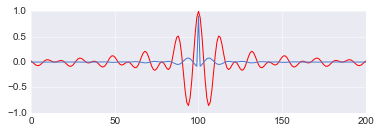

In [147]:
plt.subplot(211)


freqL = center_freq-filter_frequency_spread
freqU = center_freq+filter_frequency_spread

ffrequencies   =np.array( [ 0 ,freqL, freqL ,freqU, freqU ,nyquist ])/nyquist #transition zone of 0
filterweights  = firls(200,ffrequencies,idealresponse);
filterweights1 =  sig.firwin(201,np.array([freqL, freqU])/nyquist);


#plot wavelet and filter kernel
plt.plot(filterweights/np.max(filterweights),'r')
plt.plot(filterweights1)



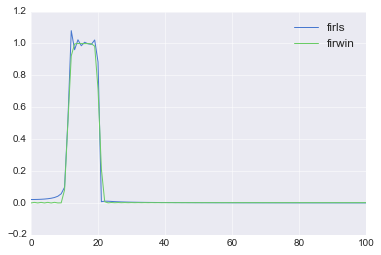

In [149]:


# plt.plot(sig.firwin2(200,np.array([0,freqL,freqL, freqU,freqU,nyquist])/nyquist,[0,0,1,1,0,0],window=("hamming")))
fft_filterweights1=1- absolute(fft(filterweights1))
fft_filterweights = absolute(fft(filterweights))

plt.plot(fft_filterweights[:int(ceil(len(filterweights)/2.))])
plt.plot(fft_filterweights1[:int(ceil(len(filterweights1)/2.))])

plt.legend(["firls","firwin"])

/Users/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  q = toeplitz(q[:M+1]) + hankel(q[:M+1], q[M : ])
/Users/arasdar/arasdar-DL-git/uri-bci-ref/firls.py:90: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  b = append(1, 1.0/i1) * array(mat(kron (cos_ints2, [1, 1]) + cos_ints[:M+1,:]) * mat(d).T)[:,0]


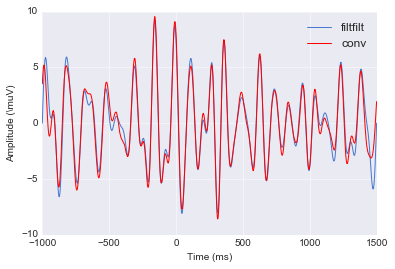

In [154]:
center_freq   = 10.
freqspread    = 4. #  Hz +/- the center frequency
transwid      = .10
ffrequencies  = np.array([ 0,
                          (1-transwid)*(center_freq-freqspread),
                          (center_freq-freqspread),
                          (center_freq+freqspread),
                          (1+transwid)*(center_freq+freqspread),
                          nyquist ])/nyquist

data2filter   = np.squeeze(EEGdata[46,:,0])
filterweights = firls(200,ffrequencies,idealresponse) # recompute without z-scoring

filter_result = sig.filtfilt(filterweights,1,data2filter)
convol_result = np.convolve(data2filter,filterweights,'same')# could also use ifft(fft(data2filter...


plot(EEGtimes,filter_result)
plot(EEGtimes,convol_result,'r')
# setp(gca(),'xlim',[-200, 1000]) # zoom-in
xlabel('Time (ms)'), ylabel('Amplitude (\muV)')
_=legend(['filtfilt','conv'])
